# NN EdgeDetector
В данном notebook приведены шаги по созданию кастомного детектора границ объектов на основании нейронных сетей и выполнено сравнение с популярным Canny edge detector.

# Шаг 1. Копирование репозитория с кодом и набором данных для обучения

In [ ]:
!git clone https://github.com/evlisouski/nn-edge-detector.git
!tar -xzf ./datasets/BSDS500.tar.gz -C ./datasets/

# Выбор /content/nn-edge-detector директории в качестве рабочего
import os
os.chdir('/content/nn-edge-detector')

# ШАГ 2. Установка необходимых зависимостей

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install opencv-python
!pip install matplotlib
!pip install scikit-learn
!pip intall Pillow

# Шаг 3. Выбор модели сети.

## Model 1. Первый вариант сети (для использования данной модели нужно закоментировать вторую модель, а эту раскомментировать)

Данная нейронная сеть представляет собой простую архитектуру для детекции границ на изображениях, основанную на принципах автоэнкодера.

- **Энкодер:**
    - Состоит из последовательности сверточных слоев и слоя максимального подвыборки:
        - **Первый сверточный слой** `nn.Conv2d(3, 64, kernel_size=3, padding=1)`:
            - Вход: 3 канала (RGB изображения).
            - Выход: 64 канала с использованием свертки размером 3x3 и padding 1.
            - Активация `nn.ReLU()`: Применяется для нелинейности.
        - **Второй сверточный слой** `nn.Conv2d(64, 128, kernel_size=3, padding=1)`:
            - Вход: 64 канала.
            - Выход: 128 каналов.
            - Активация `nn.ReLU()`.
        - **Максимальное подвыборка** `nn.MaxPool2d(2, 2)`:
            - Уменьшает размерность изображения в 2 раза, извлекая наиболее значимые признаки.

- **Декодер:**
    - Состоит из слоя транспонированной свертки и финального сверточного слоя:
        - **Транспонированная свертка** `nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)`:
            - Увеличивает размерность выходного изображения, возвращая его к более крупным размерам.
            - Активация `nn.ReLU()`.
        - **Финальный сверточный слой** `nn.Conv2d(64, 1, kernel_size=3, padding=1)`:
            - Приводит к одному каналу (выходное изображение), представляющему вероятность наличия границы.
        - **Сигмоидная активация** `nn.Sigmoid()`:
            - Преобразует значения в диапазон от 0 до 1, что подходит для бинарной классификации (граничные и не граничные пиксели), т.е. мы получаем вероятности от 0 до 1, что пиксель является частью границы.


In [1]:
# import torch.nn as nn


# class EdgeDetector(nn.Module):
#     def __init__(self):
#         super(EdgeDetector, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 1, kernel_size=3, padding=1),
#             nn.Sigmoid()  # Для бинарной задачи
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

## Model 2. Второй вариант сети.

- **Энкодер:**
    - Состоит из трех слоев, каждый из которых включает сверточный слой, нормализацию батча и активацию ReLU:
        - **encoder1**: Преобразует входные данные из 3 каналов (RGB) в 64 канала.
        - **encoder2**: Увеличивает количество каналов до 128 и применяет максимальную подвыборку для уменьшения размерности.
        - **encoder3**: Увеличивает количество каналов до 256 и также применяет максимальную подвыборку.

- **Декодер:**
    - Состоит из двух транспонированных сверточных слоев, которые увеличивают размерность выходного изображения:
        - **decoder1**: Увеличивает размерность до 128 каналов, добавляя нормализацию батча и активацию ReLU.
        - **decoder2**: Увеличивает размерность до 64 каналов и также добавляет нормализацию батча и активацию ReLU.
    - **Пропускные соединения**: Результаты из энкодеров (e2 и e1) добавляются на соответствующих уровнях декодера. Это помогает сохранить пространственную информацию и улучшает качество восстановления.

- **Финальный слой:**
    - **final_conv**: Приводит к одному каналу, который представляет вероятность наличия границы.
    - Используется функция активации `torch.sigmoid()`, чтобы привести выходные значения к диапазону от 0 до 1, что позволяет интерпретировать их как вероятности для бинарной классификации (граница или не граница).

- **Основные моменты:**
    - **Batch Normalization**: Использование `nn.BatchNorm2d` помогает нормализовать активации, улучшая стабильность и скорость обучения.
    - **Пропускные соединения**: Они особенно полезны в задачах сегментации, поскольку помогают сохранить важные детали из первоначальных слоев при восстановлении изображения.
    - **Финальная активация**: `torch.sigmoid(out)` используется для приведения значений к диапазону [0, 1], что позволяет легко интерпретировать результаты в виде вероятности.


In [2]:
import torch.nn as nn
import torch


# Пример простой нейросети для детекции границ (Unet-like модель)
class EdgeDetector(nn.Module):
    def __init__(self):
        super(EdgeDetector, self).__init__()
        
        # Энкодер
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Декодер
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Энкодинг
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        
        
        # Декодинг с пропусками
        d1 = self.decoder1(e3)
        d1 = d1 + e2  # Пропуск соединение
        d2 = self.decoder2(d1)
        d2 = d2 + e1  # Пропуск соединение
        
        out = self.final_conv(d2)
        return torch.sigmoid(out)

# Шаг 4. Объявление класса загрузчика данных для обучения

In [3]:
from torch.utils.data import Dataset
from PIL import Image


class BDSD500Dataloader(Dataset):
    def __init__(self, file_path, transform=None):
        self.paths = list(self._load_paths_from_file(file_path))
        self.transform = transform

    def _load_paths_from_file(self, file_path):
        with open(file_path, 'r') as f:
            for line in f:
                path_tmp = line.strip().split()
                if len(path_tmp) >= 2:  # Убедимся, что есть хотя бы два пути
                    yield "datasets/BSDS500/" + path_tmp[0], "datasets/BSDS500/" + path_tmp[1]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):        
        source_image_path, target_image_path = self.paths[idx]
        # print(source_image_path)

        source_image = Image.open(source_image_path).convert("RGB")
        target_image = Image.open(target_image_path).convert("L")  # Границы в черно-белом формате

        if self.transform:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image

# Шаг 5. Обучение сети (в репозитории сохранены предобученные модели, данный шаг можно пропустить)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms



def train(list_with_pair="datasets/BSDS500/train_pair.lst", num_epochs=10, info_freq=50):    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # DataLoader
    train_dataset = BDSD500Dataloader(list_with_pair, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    # Initialization of the model, loss function and optimizer
    model = EdgeDetector()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training cycle
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0    
        for i, (inputs, labels) in enumerate(train_loader):        
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Back propagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % info_freq == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    torch.save(model.state_dict(), f'./saved_models/edge_detector_{EdgeDetector.__name__}_{epoch+1}.pth')


list_with_pair = "datasets/BSDS500/train_pair.lst"  # Path to a list with image pairs for training
num_epochs = 10  # Number of epochs for training
info_freq = 50  # frequency of outputting information to the command line

train(list_with_pair=list_with_pair, num_epochs=num_epochs, info_freq=info_freq)


# Шаг 6. Инференс сети и сравнение результатов с Canny edge detector.

In [ ]:
import numpy as np


def load_model(model_path="deep_edge_model2.pth"):
    model = EdgeDetector()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model


def predict_edges(model, image_path, threshold=0):
    transform = transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.ToTensor(),])
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_image)
    output_image = output.squeeze().cpu().numpy()
    output_image = Image.fromarray(output_image)
    output_image = output_image.resize((width, height), Image.Resampling.BILINEAR)
    output_image = np.array(output_image)
    if threshold > 0:
        output_image = (output_image > threshold).astype(np.uint8)
    return output_image


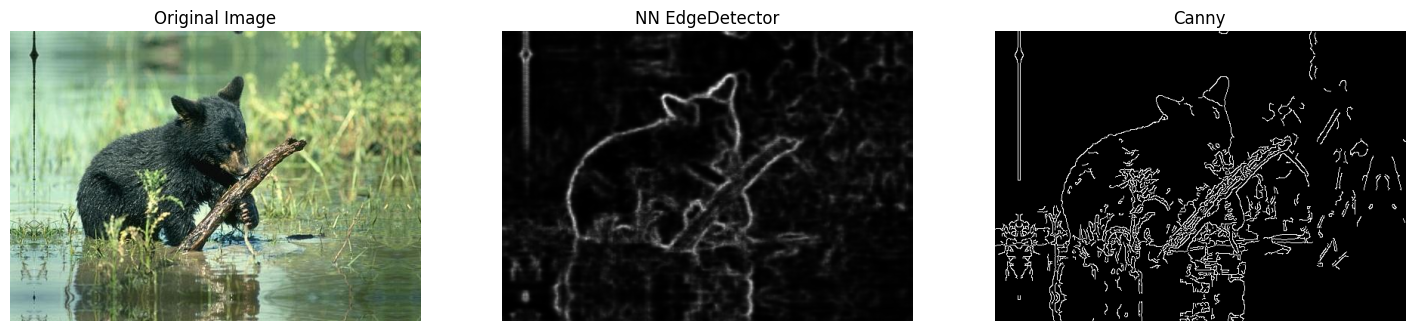

In [7]:
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


def canny_detect_edges(image_path, sigma=1.0):
    original_image = Image.open(image_path).convert("RGB")
    image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
    blurred_image = cv2.GaussianBlur(image, (0, 0), sigma)
    edges_canny = cv2.Canny(blurred_image, 100, 200)
    return edges_canny


def read_original_image(image_path):
    original_image_pil = Image.open(image_path).convert("RGB")
    original_image_cv = cv2.cvtColor(np.array(original_image_pil), cv2.COLOR_RGB2BGR)
    return original_image_cv

def show_results(original_image_cv, output_image, edges_canny):
    '''Displays the original image, the edges predicted by the model,
    and the bounedges daries obtained through the Canny filter.'''

    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB))  # Конвертация обратно в RGB для отображения
    plt.axis("off")

    # NN image
    plt.subplot(1, 3, 2)
    plt.title("NN EdgeDetector")
    plt.imshow(output_image, cmap="gray")
    plt.axis("off")

    # Canny image
    plt.subplot(1, 3, 3)
    plt.title("Canny")
    plt.imshow(edges_canny, cmap="gray")
    plt.axis("off")

    plt.show()


def calculate_score(images_path='datasets/BSDS500/train/aug_data/0.0_1_0',
                    masks_path='datasets/BSDS500/train/aug_gt/0.0_1_0',
                    model_path="saved_models/edge_detector_model_2.pth"):

    model = load_model(model_path)

    image_paths = [os.path.join(images_path, fname) for fname in os.listdir(images_path)[:200]]
    mask_paths = [os.path.join(masks_path, fname) for fname in os.listdir(masks_path)[:200]]

    predicted_edges_nn = []
    predicted_edges_canny = []

    for img_path, mask_path in zip(image_paths, mask_paths):    
        nn_res = predict_edges(model=model, image_path=img_path)
        nn_res = (nn_res > 0.06).astype(np.uint8)
        predicted_edges_nn.append(nn_res)
                
        canny_res = canny_detect_edges(image_path=img_path)
        predicted_edges_canny.append(canny_res)

    true_masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

    def calculate_metrics(predicted_edges, true_masks):
        total_precision = 0
        total_recall = 0
        total_f1 = 0
        num_images = len(predicted_edges)

        for pred_edge, true_mask in zip(predicted_edges, true_masks):
            predicted_edges_binary = (pred_edge > 0).astype(int)
            true_masks_binary = (true_mask > 0).astype(int)

            precision = precision_score(true_masks_binary.flatten(), predicted_edges_binary.flatten())
            recall = recall_score(true_masks_binary.flatten(), predicted_edges_binary.flatten())
            f1 = f1_score(true_masks_binary.flatten(), predicted_edges_binary.flatten())

            total_precision += precision
            total_recall += recall
            total_f1 += f1

        average_precision = total_precision / num_images
        average_recall = total_recall / num_images
        average_f1 = total_f1 / num_images

        return average_precision, average_recall, average_f1

    # Вычисление метрик для нейронной сети
    precision_nn, recall_nn, f1_nn = calculate_metrics(predicted_edges_nn, true_masks)
    # Вычисление метрик для Canny
    precision_canny, recall_canny, f1_canny = calculate_metrics(predicted_edges_canny, true_masks)
    # Вывод результатов
    print(f"NN Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}, F1: {f1_nn:.4f}")
    print(f"Canny Precision: {precision_canny:.4f}, Recall: {recall_canny:.4f}, F1: {f1_canny:.4f}")


model_path = "saved_models/edge_detector_model_2.pth"  
images_path = "datasets/BSDS500/train/aug_data/0.0_1_0"
masks_path = "datasets/BSDS500/train/aug_gt/0.0_1_0"  
random_image_from_dataset = random.choice([os.path.join(images_path, fname) for fname in os.listdir(images_path)[:200]])

model = load_model(model_path)    
edges_predict = predict_edges(model, image_path=random_image_from_dataset)
edges_canny = canny_detect_edges(image_path=random_image_from_dataset)
original_image = read_original_image(image_path=random_image_from_dataset)
show_results(original_image, edges_predict, edges_canny)
# calculate_score(images_path, masks_path, model_path)


# Выводы. Canny vs Нейронные сети

## 1. Алгоритм Canny
- **Принцип работы**: Классический метод, основанный на градиенте изображения.
- **Преимущества**:
  - Быстрота и высокая производительность.
  - Низкие требования к вычислительным ресурсам.
  - Настраиваемая точность и чувствительность.
- **Недостатки**:
  - Ограниченная гибкость и возможность выделения шума.
  - Плохая работа с низкокачественными изображениями.
  - Не подходит для семантического понимания объектов.
- **Рекомендации по применению**:
  - Хорош для простых задач и систем реального времени.

## 2. Нейронные сети
- **Принцип работы**: Используют архитектуры, обученные на задачах выделения границ.
- **Преимущества**:
  - Высокая гибкость и точность.
  - Эффективность на низкокачественных изображениях.
  - Возможность предсказания семантических границ.
- **Недостатки**:
  - Высокие требования к вычислительным ресурсам.
  - Долгое время на обучение и разработку.
  - Проблемы с обобщением.
- **Рекомендации по применению**:
  - Подходят для сложных изображений и задач, где важна точность.

# Список использованных источников

1. [Canny Edge Detection](https://en.wikipedia.org/wiki/Canny_edge_detector)  
   *Статья на Wikipedia, описывающая алгоритм Canny и его основные этапы.*

2. [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)  
   *Исходная работа по U-Net, популярной архитектуре для задач сегментации, включая обнаружение границ.*

3. [Plot edge PR curves](https://github.com/yun-liu/plot-edge-pr-curves/)  
   *Сравнение различных моделей и методов обнаружения границ объектов*

4. [HED BSDS dataset](https://www.kaggle.com/datasets/rajatnagar/hed-bsds)  
   *Датасет BSDS500 с аугментацией и преобразованными масками из mat в png*

4. [OpenCV Documentation](https://docs.opencv.org/)  
   *Официальная документация OpenCV, содержащая информацию о реализации алгоритма Canny и других методов обработки изображений.*

5. [Scikit-learn Metrics](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics)  
   *Документация по метрикам оценки, используемым для анализа результатов обнаружения границ, таких как precision, recall и F1-score.*
